In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

# 1. Data Process

## 1.1 Collect Data

In [3]:
data_sg = pd.read_csv('../data/SG_data.csv')
data_us = pd.read_csv('../data/USA_data.csv')
data_cn = pd.read_csv('../data/China_data.csv')
data_all = pd.concat([data_sg, data_us, data_cn], ignore_index = True)

data = data_all
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2946 entries, 0 to 2945
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   location                         2946 non-null   object 
 1   date                             2946 non-null   object 
 2   total_cases_per_million          2946 non-null   float64
 3   new_cases_per_million            2946 non-null   float64
 4   total_deaths_per_million         2946 non-null   float64
 5   new_deaths_per_million           2946 non-null   float64
 6   stringency_index                 2946 non-null   float64
 7   hospital_beds_per_thousand       2946 non-null   float64
 8   testing_policy                   2946 non-null   int64  
 9   contact_tracing                  2946 non-null   int64  
 10  facial_coverings                 2946 non-null   int64  
 11  restrictions_internal_movements  2946 non-null   int64  
 12  international_travel

## 1.2 Check Data With The Correlation

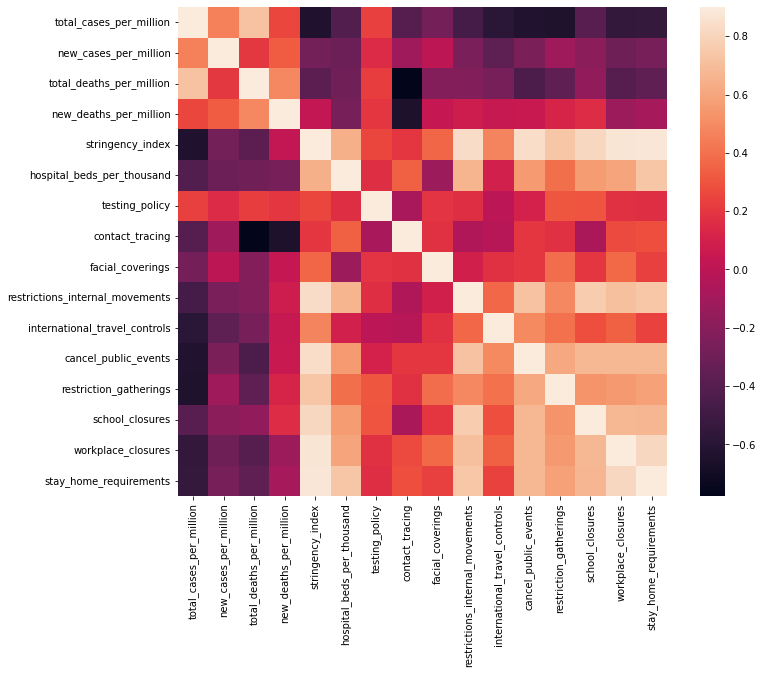

In [4]:
corr=data.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corr,vmax=0.9,square=True,linecolor='white')
plt.show()

In [5]:
# sns.set()
# c_scatter= [data.keys()[i] for i in [2,10,11,12]]
# pair_scatter=sns.pairplot(data[c_scatter],height=2.5)
# plt.show()

## 1.3 Data Split

In [6]:
y_name = 'total_cases_per_million'
# y_name = 'new_cases_per_million'

x = data.iloc[:, 6:]
y = data.loc[:, y_name]

y = np.log(y + 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state = 0)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(2356, 12) (590, 12) (2356,) (590,)


In [7]:
print(y.describe())

count    2946.000000
mean        8.232975
std         3.411922
min         0.002996
25%         4.336993
50%         9.243214
75%        11.480846
max        12.732164
Name: total_cases_per_million, dtype: float64


# 2. Regression

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge 
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

## 2.1 Linear Regression

### fit model

In [9]:
model_LR = LinearRegression()
model_LR.fit(x_train, y_train)

print(model_LR.coef_, model_LR.intercept_)

[ 0.08750056 -2.07232311  2.83989938 -2.57645047  0.71651716 -0.85293322
 -1.11721707  0.3438343  -0.56985027 -0.53254065  0.06075841 -0.49007226] 10.492738711836356


### predict

In [10]:
y_pred = model_LR.predict(x_test)

### evaluation

In [11]:
print("MSE: {}".format(MSE(y_pred, y_test)))
print("R2: {}".format(r2_score(y_pred, y_test)))

MSE: 1.3946467353985341
R2: 0.8619009405140474


## 2.2 Ridge Regression

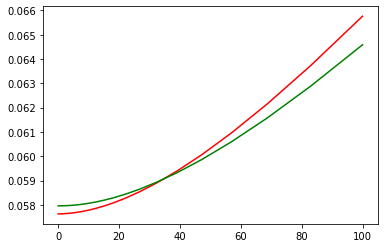

In [12]:
alphas=np.logspace(-2,2,50)
test_scores1=[]
test_scores2=[]
for alpha in alphas:
    clf=Ridge(alpha)
    scores1=np.sqrt(cross_val_score(clf,x_train,y_train,cv=5))
    scores2=np.sqrt(cross_val_score(clf,x_train,y_train,cv=10))
    test_scores1.append(1-np.mean(scores1))
    test_scores2.append(1-np.mean(scores2))
plt.plot(alphas,test_scores1,color='red')
plt.plot(alphas,test_scores2,color='green')

### fit model

In [13]:
model_ridge=Ridge(alpha=10)
model_ridge.fit(x_train, y_train)

Ridge(alpha=10)

### predict

In [14]:
y_pred = model_ridge.predict(x_test)

### evaluation

In [15]:
print("MSE: {}".format(MSE(y_pred, y_test)))
print("R2: {}".format(r2_score(y_pred, y_test)))

MSE: 1.3885504136504465
R2: 0.8600429765298029


## 2.3 Random Forest

### compare the value of max_features

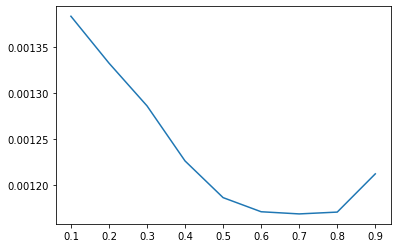

In [16]:
max_features=[.1,.2,.3,.4,.5,.6,.7,.8,.9]
# max_features=[.1,.3,.5,.7,.9]

test_scores=[]

for max_feature in max_features: 
    clf=RandomForestRegressor(max_features=max_feature,n_estimators=100)
    score=np.sqrt(cross_val_score(clf,x_train,y_train,cv=5))
    test_scores.append(1-np.mean(score))
    
plt.plot(max_features,test_scores)

### fit model

In [17]:
model_RF = RandomForestRegressor(max_features=0.7,n_estimators=100)
model_RF.fit(x_train,y_train)

RandomForestRegressor(max_features=0.7)

### predict

In [18]:
y_pred = model_RF.predict(x_test)

### evaluation

In [19]:
print("MSE: {}".format(MSE(y_pred, y_test)))
print("R2: {}".format(r2_score(y_pred, y_test)))

MSE: 0.022939375232417878
R2: 0.9979572329347511


# 3. Feature Importance

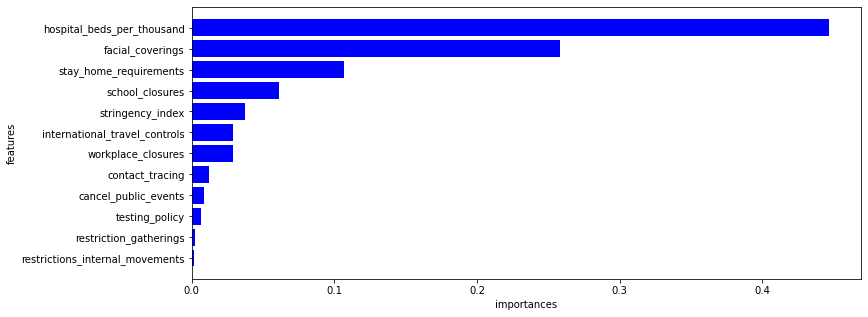

Index(['restrictions_internal_movements', 'restriction_gatherings',
       'testing_policy', 'cancel_public_events', 'contact_tracing',
       'workplace_closures', 'international_travel_controls',
       'stringency_index', 'school_closures', 'stay_home_requirements',
       'facial_coverings', 'hospital_beds_per_thousand'],
      dtype='object')


In [31]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
featureArray = x.columns
FI = pd.Series(model_RF.feature_importances_, index = featureArray) 

FI = FI.sort_values(ascending = True)
fig = plt.figure(figsize=(12,5))
plt.barh(FI.index,FI.values,color="blue")
plt.xlabel('importances')
plt.ylabel('features')
plt.show()

print(FI.index)

# 4. One country VS Multiple countries

In [64]:
def RF_train(data):
    y_name = 'total_cases_per_million'
    x = data.iloc[:, 6:]
    y = data.loc[:, y_name]
    y = np.log(y + 1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state = 0)
    
    model = LinearRegression()
#     model = RandomForestRegressor(max_features=0.5,n_estimators=100)
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    
    mse = MSE(y_pred, y_test)
    r2 = r2_score(y_pred, y_test)
    print("MSE: {}".format(mse))
    print("R2: {}".format(r2))
    
    return mse, r2

In [65]:
myDict = {"SG": data_sg, "US": data_us, "CN": data_cn, "ALL": data_all}
myMSE = {}
myR2 = {}
for name,d in myDict.items():
    print(name)
    mse, r2 = RF_train(d)
    myMSE[name] = mse
    myR2[name] = r2

SG
MSE: 0.6860693210247916
R2: 0.8508438000609267
US
MSE: 0.8282846170012879
R2: 0.884241379050708
CN
MSE: 0.24422291487382156
R2: 0.6195861233251683
ALL
MSE: 1.3946467353985341
R2: 0.8619009405140474


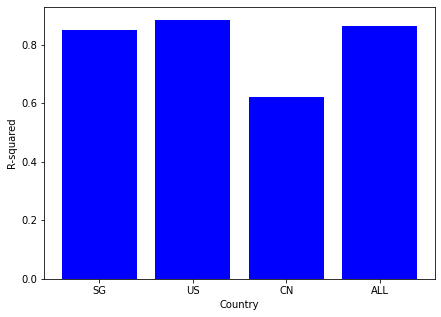

In [68]:
FI = pd.Series(myR2.values(), index = myR2.keys()) 

# FI = FI.sort_values(ascending = True)
fig = plt.figure(figsize=(7,5))
plt.bar(FI.index,FI.values,color="blue")
plt.ylabel('R-squared')
plt.xlabel('Country')
plt.show()

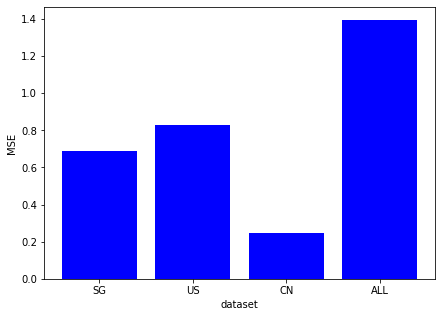

In [67]:
FI = pd.Series(myMSE.values(), index = myMSE.keys()) 

# FI = FI.sort_values(ascending = True)
fig = plt.figure(figsize=(7,5))
plt.bar(FI.index,FI.values,color="blue")
plt.ylabel('MSE')
plt.xlabel('dataset')
plt.show()